In [1]:
from model import Deeplabv3
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
import numpy as np
from model import Deeplabv3
from keras.preprocessing import image

deeplab_model = Deeplabv3(input_shape=(224,224,3),backbone='xception',weights=None,classes=23)
deeplab_model.load_weights('./models/deeplab_2.hdf5')

Using TensorFlow backend.


In [2]:
colormap =[[0, 0, 0],
 [15, 15, 15],
 [16, 16, 16],
 [17, 17, 17],
 [18, 18, 18],
 [21, 21, 21],
 [23, 23, 23],
 [24, 24, 24],
 [30, 30, 30],
 [41, 41, 41],
 [42, 42, 42],
 [43, 43, 43],
 [45, 45, 45],
 [46, 46, 46],
 [47, 47, 47],
 [49, 49, 49],
 [50, 50, 50],
 [54, 54, 54],
 [56, 56, 56],
 [62, 62, 62],
 [65, 65, 65],
 [90, 90, 90],
 [255, 255, 255]]
# colormap=[[0,0,0],[255,255,255]]
#labelVisualize传递进来的是一个二维的索引数组（针对于只有一张图片的时候），即里面只有数字0～20
import matplotlib.pyplot as plt
def labelVisualize(num_class,color_dict,img):
    #把二维的索引数组根据索引转换为正常的rgb图片
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]

    img_out/=255.

    return img_out

#将21通道的三维数组转化为二维的索引数组
def label2image(label):
    two_array=np.zeros(label[:,:,0].shape)
    idx=np.argwhere(label==1)
    for each in idx:
        two_array[each[0],each[1]]=each[2]

    return two_array

In [3]:
# coding:utf-8
import numpy as np
import cv2
import tensorflow as tf
from libtiff import TIFF
import matplotlib.pyplot as plt
from skimage import io

img_size = 224

file_dir = './test_images/'


def get_mask(imgs):
    imgs = imgs.swapaxes(1, 2).swapaxes(2, 3)
    masks = []
    for img in imgs:
        img/=255.
        img = np.expand_dims(img, axis=0)
#         img/=255.
        mask = deeplab_model.predict([img])
        masks.append(mask)
    return np.array(masks)


# import gdal
def readTif(file_name, isMask=False):
    '''
    读取一张tif格式的图片，返回图片的宽、高、通道数目、图片的array
    注：用io.imread()读取tif和用
    '''
    image=io.imread(file_dir+file_name)
    im_width = image.shape[1]
    im_height = image.shape[0]
    im_bands = 1
    if not isMask:
        im_width = image.shape[1]
        im_height = image.shape[0]
        im_bands = image.shape[2]
        image = image.swapaxes(0, 2)
        im_data = image.swapaxes(1, 2)
        image = im_data
#     print('readtif: image.shape',image.shape) #(4,3953,2833)(通道，高，宽) mask:(3952,2832)(高，宽)
    return {'width': im_width, 'height': im_height, 'band_num': im_bands, 'data': image}


def divide(img):
    imgs = np.array([])
    bands, height, width = img.shape
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            temp=img[:, row:row + img_size, col:col + img_size]
            temp=(temp/np.max(temp))*255.
            imgs = np.append(imgs, temp)
    imgs = imgs.reshape([-1, 3, 224, 224])
#     print(imgs)
    return imgs


def union(imgs, height, width):
    img = np.zeros((height, width,3))
    id = 0
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            img[row:row + img_size, col:col + img_size] = imgs[id]
            id += 1
    return img


./test_images/01.tif


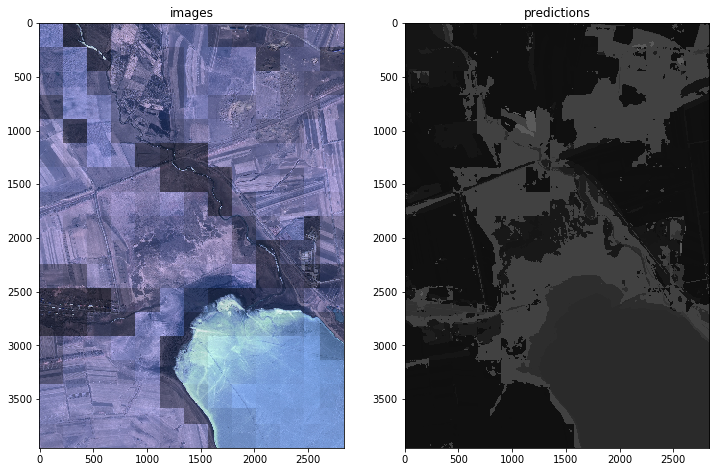

In [6]:
#每次读取一张大的tif图，切割，切割后的小图先保存为jpg的图像，然后再读取图像，将读取的图像做predict，再把经过predict的小图通过union函数整合成一张大图，然后保存并显示大图
#麻烦之处在于不能直接将切割后的小图的数组输入到模型中做predict，这样子predict的结果有问题，原因在于生成图片后再读取图片所读出来的数组与下面＃1处的数组不一样，原因未知
from shutil import rmtree
import os
if not os.path.exists('./tmp_imgs'):
    os.mkdir('./tmp_imgs')
for id in range(1,2):
    # 读取原图
    img_name = '%02d.tif'%id
    print('./test_images/%s'%(img_name))
    
    img = cv2.imread('./test_images/%s'%(img_name), -1)
    fig = plt.figure(figsize=(12, 12))
#     fig.add_subplot(1, 3, 1)
#     plt.title('images')
#     plt.imshow(img)

    # 显示预测的mask图
    xs, ys = [], []
    img = readTif(img_name)
    width, height, bands, data = img['width'], img['height'], img['band_num'], img['data']
#     print('data.shape',data.shape)
    data=data[:3,:,:]
    imgs = divide(data)
#     print('切割过后图像的大小',imgs.shape)
    new_imgs=[]
    for i in range(imgs.shape[0]):
        #1
        img_s=imgs[i,:,:,:].swapaxes(0,1).swapaxes(1,2)

        cv2.imwrite('./tmp_imgs/imgs_%d.jpg'%i,img_s)

        xx=image.load_img('./tmp_imgs/imgs_%d.jpg'%i)
        xx=image.img_to_array(xx)
        xx=xx/255.
        new_imgs.append(xx)
        
    #将切割后的小图拼接为大图，容易显示
    ori_img=union(new_imgs,height,width)
#     print(ori_img.shape)
    fig.add_subplot(1,2,1)
    plt.title('images')
    plt.imshow(ori_img)
    
    
    new_imgs=np.array(new_imgs)
    fina_mask=[]
    for j in range(imgs.shape[0]):
        pre=deeplab_model.predict(np.expand_dims(new_imgs[j],axis=0))
        mask = pre.argmax(axis=-1)[...,None] == np.arange(pre.shape[-1])
        out = mask.astype('int')
        
        x=label2image(out[0,:,:,:])
        new_label=labelVisualize(23,colormap,x)
        fina_mask.append(new_label)
    fina_mask=np.array(fina_mask)
    fina_mask=union(fina_mask,height,width)
    fig.add_subplot(1,2,2)
    plt.title('predictions')
    plt.imshow(fina_mask)
    cv2.imwrite('./results/%d.png'%id,fina_mask)        
rmtree('./tmp_imgs')